This notebook uses our own EEG library to reproduce the N400 effect in the naturalistic dataset of Frank et al. 2015.
It compares with the epoched ERP output produced by `Frank N400 sanity check.ipynb`.
The output is used in the Rmd notebook corresponding to this file for a regression analysis.

In [1]:
from pathlib import Path

import mne
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/frank2015")

EPOCH_WINDOW = (-0.1, 0.924)
TEST_WINDOW = (0.3, 0.5)
BASELINE_WINDOW = (None, 0)

N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from mfn400.adapters.frank2015 import FrankDatasetAdapter
from mfn400.n400 import prepare_erp_df

In [4]:
data = FrankDatasetAdapter(DATA_DIR, basedir / "output/frank2015/stim_df.csv")

In [5]:
epochs = data.to_erp(EPOCH_WINDOW, baseline=None)

In [6]:
erp_df = pd.concat([prepare_erp_df(epochs[subject], data.get_presentation_data(subject),
                                   test_window=TEST_WINDOW,
                                   apply_baseline=False, baseline=BASELINE_WINDOW)
                    for subject in tqdm(epochs)],
                   names=["subject_idx"], keys=[int(idx) for idx in epochs.keys()])

# Filter out stimuli of .. unknown origin.
erp_df = erp_df.loc[erp_df.sentence_idx != -1]
erp_df

  0%|          | 0/24 [00:00<?, ?it/s]

level_0  onset_time  word_idx  sentence_idx  index  \
subject_idx                                                            
1           0           1       9.824         0           105  762.0   
            1           2      10.496         1           105  763.0   
            2           3      11.236         2           105  764.0   
            3           4      11.924         3           105  765.0   
            4           5      12.720         4           105  766.0   
...                   ...         ...       ...           ...    ...   
24          1926     2131    1991.376         1             4   17.0   
            1927     2132    1992.104         2             4   18.0   
            1928     2133    1992.804         3             4   19.0   
            1929     2134    1993.476         4             4   20.0   
            1930     2135    1994.172         5             4   21.0   

                       word  surprisal  word_len  item condition  ...  \
subject_idx                                                       ...   
1           0            He        NaN       2.0   105       155  ...   
            1        heaved  12.092188       6.0   105         2  ...   
            2           his   2.567430       3.0   105         3  ...   
            3     shoulders   4.748672       9.0   105         4  ...   
            4           and   1.812982       3.0   105         5  ...   
...                     ...        ...       ...   ...       ...  ...   
24          1926      don't   5.924694       5.0     4         2  ...   
            1927       want   0.001599       4.0     4         3  ...   
            1928         to   2.467195       2.0     4         4  ...   
            1929       hear   0.337823       4.0     4         5  ...   
            1930        it.   3.836645       3.0     4         6  ...   

                  29_baseline  26_baseline  18_baseline  10_baseline  \
subject_idx                                                            
1           0       -1.552422    -1.423502   -11.599051   -16.289716   
            1       -0.975369    -1.338748    -7.620269    -8.837487   
            2        2.017186     5.011338    -0.965601     7.512299   
            3        5.943697     9.171171     7.021311    21.994323   
            4      -15.407347   -15.373237    -1.216896    13.721882   
...                       ...          ...          ...          ...   
24          1926     1.097889    16.041867    13.999779    -5.592605   
            1927     2.468472    19.659056    17.125322     6.825893   
            1928     6.493339    22.989720    21.534514    17.562856   
            1929    18.125691    35.230592    25.574189    27.517876   
            1930     2.879284    14.080728    10.708722    13.343332   

                  16_baseline  12_baseline  14_baseline  1_baseline  \
subject_idx                                                           
1           0       12.632056     0.373985    -4.347957    7.199101   
            1       -1.344282    -4.430803    -4.105059   -1.985957   
            2       -6.963580     0.930380     3.168724    0.728866   
            3       -8.637939     5.933740    11.232977    4.870999   
            4      -34.550160   -17.292068   -13.854310  -21.454966   
...                       ...          ...          ...         ...   
24          1926    10.141236    12.999357    16.477723   -4.639908   
            1927    13.568453    26.478204    17.830269    5.265121   
            1928    20.244952    34.893024    19.857496   13.239361   
            1929    29.900061    46.513278    30.168731   25.224219   
            1930    12.916364    20.991087     4.362809   10.219391   

                  35_baseline  8_baseline  
subject_idx                                
1           0      -68.823149  -18.913741  
            1      -36.339572   -7.092790  
            2       -2.088828    9.187208  
            3       24.778733   25.674471  
      

---

## Sanity check

Compare with N400 values from epoched data in Frank dataset (converted to our format in the notebook "Frank N400 sanity check.ipynb" in this repo).

In [7]:
import seaborn as sns

In [8]:
reference_df = pd.read_csv(basedir / "output/frank_erp_n400.csv", index_col=["subject_idx", "sentence_idx", "word_idx"])
reference_df = reference_df

In [9]:
our_erp_df = erp_df.copy()
# Average over N400 electrodes as given in paper.
our_erp_df = our_erp_df.reset_index().set_index(["subject_idx", "sentence_idx", "word_idx", "surprisal"]) \
    .loc[:, N400_ELECTRODES].mean(axis=1).rename("our_N400")
our_erp_df = pd.DataFrame(our_erp_df).reset_index("surprisal")
our_erp_df

surprisal   our_N400
subject_idx sentence_idx word_idx                      
1           105          0               NaN   1.320969
                         1         12.092188  -7.101564
                         2          2.567430   2.804468
                         3          4.748672   5.169088
                         4          1.812982   4.396452
...                                      ...        ...
24          4            1          5.924694   9.213798
                         2          0.001599  11.290841
                         3          2.467195  14.714495
                         4          0.337823  13.254220
                         5          3.836645  16.286858

[45715 rows x 2 columns]

In [10]:
our_baseline_df = erp_df.reset_index().set_index(["subject_idx", "sentence_idx", "word_idx"]) \
    .loc[:, [f"{el}_baseline" for el in N400_ELECTRODES]].mean(axis=1).rename("our_baseline")
our_baseline_df.head()

subject_idx  sentence_idx  word_idx
1            105           0          -4.232241
                           1          -3.859356
                           2           3.013608
                           3           7.791294
                           4          -9.305579
Name: our_baseline, dtype: float64

In [11]:
reference_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  \
subject_idx sentence_idx word_idx                                     
1           1            0                3.145689         3.121044   
                         1                8.214565         7.030273   
                         2                8.330564         6.914139   
                         3                3.210452         2.787990   
                         4                8.541803         8.242652   
...                                            ...              ...   
24          205          7                3.924689         3.901125   
                         8                7.945024         6.722867   
                         9                9.959173         8.835783   
                         10               3.884360         3.874658   
                         11               8.574935         8.116138   

                                   surp_rnn_size_4  surp_rnn_size_5  \
subject_idx sentence_idx word_idx                           

In [12]:
# Double-check indexing.
for level in ["subject_idx", "sentence_idx"]:
    assert set(reference_df.index.get_level_values(level)) == set(our_erp_df.index.get_level_values(level)), level
    assert set(our_erp_df.index.get_level_values(level)) == set(our_baseline_df.index.get_level_values(level)), level

In [13]:
comp_df = pd.merge(reference_df, our_erp_df, left_index=True, right_index=True)
comp_df = pd.merge(comp_df, our_baseline_df, left_index=True, right_index=True)
comp_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  ...  \
subject_idx sentence_idx word_idx                                    ...   
1           1            0                3.145689         3.121044  ...   
                         1                8.214565         7.030273  ...   
                         2                8.330564         6.914139  ...   
                         3                3.210452         2.787990  ...   
                         4                8.541803         8.242652  ...   
...                                            ...              ...  ...   
24          205          7                3.924689         3.901125  ...   
                         8                7.945024         6.722867  ...   
                         9                9.959173         8.835783  ...   
                         10               3.884360         3.874658  ...   
                         11               8.574935         8.116138  ...   

                                   surp_rnn_size_6  surp_rnn_size_

<AxesSubplot:xlabel='value_N400', ylabel='our_N400'>

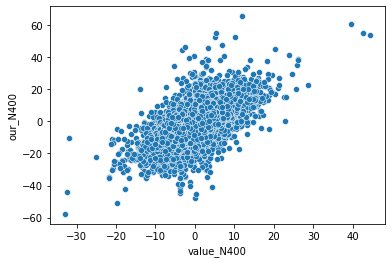

In [14]:
sns.scatterplot(data=comp_df.reset_index(), x="value_N400", y="our_N400")

<AxesSubplot:xlabel='base_N400', ylabel='our_baseline'>

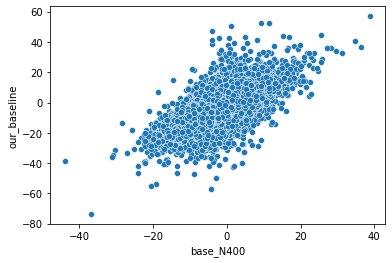

In [15]:
sns.scatterplot(data=comp_df.reset_index(), x="base_N400", y="our_baseline")

### Test similarity of surprisals

In [19]:
import scipy.stats
test_df = comp_df.dropna().reset_index()
test_df = test_df.loc[test_df.word_idx != 0]

(0.6935061903271316, 0.0)

(0.6935061903271316, 0.0)

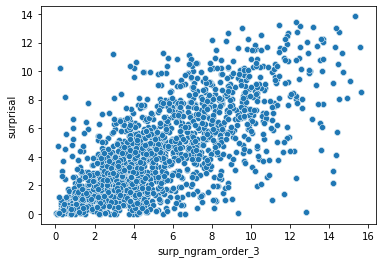

In [22]:
sns.scatterplot(data=test_df.reset_index(), x="surp_ngram_order_3", y="surprisal")
scipy.stats.pearsonr(test_df.surp_ngram_order_3, test_df.surprisal)

(0.5909612094702004, 0.0)

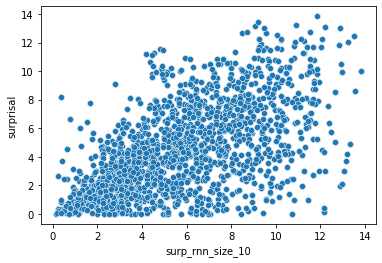

In [23]:
sns.scatterplot(data=test_df.reset_index(), x="surp_rnn_size_10", y="surprisal")
scipy.stats.pearsonr(test_df.surp_rnn_size_10, test_df.surprisal)

## Output for R regression

In [21]:
comp_df.to_csv(basedir / "output/frank_erp_n400-repro.csv")

---

## Stim analysis debugging

In [22]:
import os
os.environ["TRANSFORMERS_CACHE"] = "/om2/user/jgauthie/scratch/broderick2018/transformers_cache"

import sys
sys.path.append("../scripts")
import frank2015_stimuli

In [24]:
sentences = ["I cannot tell you more.".split(), "Helen ran to the toilet.".split()]

In [21]:
surp_df = frank2015_stimuli.compute_surprisals(sentences, model="EleutherAI/gpt-neo-125M")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16416.06it/s]


In [22]:
surp_df

,global_text_word_idx,sent_idx,text_word_idx,tok_idx,surprisal
0,0,0,0,0,6.587284
1,1,0,1,1,3.291662
2,2,0,2,2,0.380805
3,3,0,3,3,6.757507
4,4,0,4,4,3.373745
5,5,1,0,0,2.132782
6,5,1,0,1,10.140997
7,6,1,1,2,2.806770
8,7,1,2,3,1.065191
9,8,1,3,4,6.498016


In [34]:
data.stimulus_df.tail(40)

index      word  surprisal  word_len
sentence_idx word_idx                                      
203          0          1891       One   5.718135         3
             1          1892        by   1.215533         2
             2          1893       one   6.044756         3
             3          1894       she   7.363119         3
             4          1895    placed   1.777084         6
             5          1896       her   6.254961         3
             6          1897     teeth   6.401275         5
             7          1898     about   5.146311         5
             8          1899     their   0.960694         5
             9          1900     necks   1.746907         5
             10         1901       and   8.002415         3
             11         1902    killed   0.929090         6
             12         1903     them.   1.180266         5
204          0          1904         I   6.221462         1
             1          1905      know  10.112596         4
             2          1906   Richard  13.222027         7
             3          1907    drinks   1.825533         6
             4          1908         a   3.582905         1
             5          1909    little   1.519684         6
             6          1910       too   0.035204         3
             7          1911      much   2.563769         4
             8          1912       and   3.759393         3
             9          1913       has   1.279395         3
             10         1914         a   3.809714         1
             11         1915       bit   0.158157         3
             12         1916        of   0.525066         2
             13         1917         a   3.036670         1
             14         1918   temper.   1.480951         7
205          0          1919        In   2.622173         2
             1          1920       the   5.781035         3
             2          1921   morning  12.999873         7
             3          1922    Mickey   6.271266         6
             4          1923     stood   6.802099         5
             5          1924  straight   4.565966         8
             6          1925      with   0.768233         4
             7          1926       his   3.621157         3
             8          1927      hand   3.868340         4
             9          1928    behind   0.067876         6
             10         1929       his   0.416604         3
             11         1930     back.   1.511487         5

In [25]:
import mfn400.transformers_utils

In [26]:
import transformers

In [35]:
ref = "gpt2"
encoding, surps = mfn400.transformers_utils.get_predictive_outputs(
    transformers.AutoModelForCausalLM.from_pretrained(ref, is_decoder=True), 
    transformers.AutoTokenizer.from_pretrained(ref),
    ["In the morning Mickey stood straight with his hand behind his back.".split()])

In [41]:
tok = transformers.AutoTokenizer.from_pretrained(ref)

In [42]:
len(tok.tokenize("In the morning Mickey stood straight with his hand behind his back."))

13

In [43]:
surps[0].shape

(13, 50257)

In [40]:
encoding["input_ids"][0]

[818, 262, 3329, 27232, 6204, 3892, 351, 465, 1021, 2157, 465, 736, 13]

In [53]:
list(zip(encoding.tokens()[1:], [surps[0][idx, encoding["input_ids"][0][idx + 1]] for idx in range(12)]))

[('Ġthe', 2.622173),
 ('Ġmorning', 5.7810354),
 ('ĠMickey', 12.999873),
 ('Ġstood', 6.271266),
 ('Ġstraight', 6.8020988),
 ('Ġwith', 4.5659657),
 ('Ġhis', 0.7682327),
 ('Ġhand', 3.6211565),
 ('Ġbehind', 3.8683405),
 ('Ġhis', 0.067875706),
 ('Ġback', 0.41660383),
 ('.', 1.5114868)]

In [83]:
frank2015_stimuli.compute_surprisals(["In the morning Mickey stood straight with his hand behind his back.".split()],
                                     model="gpt2")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.8.crossattention.q_attn.weight', 'h.4.crossattention.masked_bias', 'h.7.ln_cross_attn.weight', 'h.10.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.bias', 'h.0.ln_cross_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.9.crossattention.c_proj.bias', 'h.10.crossattention.masked_bias', 'h.2.crossattention.c_proj.bias', 'h.6.ln_cross_attn.weight', 'h.0.crossattention.bias', 'h.1.crossattention.masked_bias', 'h.9.crossattention.c_proj.weight', 'h.1.crossattention.bias', 'h.2.crossattention.c_attn.weight', 'h.0.crossattention.c_attn.weight', 'h.8.crossattention.c_proj.weight', 'h.8.crossattention.masked_bias', 'h.2.crossattention.masked_bias', 'h.6.crossattention.c_attn.weight', 'h.11.crossattention.c_attn.weight', 'h.1.ln_cross_attn.weight', 'h.3.crossattention.c_proj.weight', 'h.5.crossattention.c_proj.bias', 'h.1.crossattentio

here


,global_text_word_idx,sent_idx,text_word_idx,tok_idx,surprisal
0,1,0,1,1,2.622173
1,2,0,2,2,5.781035
2,3,0,3,3,12.999873
3,4,0,4,4,6.271266
4,5,0,5,5,6.802099
5,6,0,6,6,4.565966
6,7,0,7,7,0.768233
7,8,0,8,8,3.621156
8,9,0,9,9,3.868340
9,10,0,10,10,0.067876


In [82]:
"In the morning Mickey stood straight with his hand behind his back.".split()[12]

IndexError: list index out of range

---

In [35]:
import mne

In [36]:
m2 = mne.io.read_raw_eeglab("/om/data/public/language-eeg/frank2015/EEG02.set", preload=True)
m1 = mne.io.read_raw_eeglab("/om/data/public/language-eeg/frank2015/EEG01.set", preload=True)

# NB EEG data recorded during sentence boundaries is marked as NaN in the raw data. this is awkward. maybe best to split data at NaN boundaries, then rebuild with `concatenate_raw` (so boundaries don't get messed up during epoching)

KeyboardInterrupt: 

In [ ]:
montage = mne.channels.make_standard_montage("easycap-M10")

In [ ]:
montage.plot()

In [ ]:
m1.info["highpass"] = 0.25

In [ ]:
m1_mat = m1.get_data()

In [ ]:
import numpy as np

# Get indices into raw EEG data where stimulus presentation begins
# (i.e. index i s.t. data[i] is not NaN and data[i - 1] is NaN)
presentation_begins = np.where(~np.isnan(m1_mat[0, 1:]) & np.isnan(m1_mat[0, :-1]))[0]
presentation_ends = np.where(~np.isnan(m1_mat[0, :-1]) & np.isnan(m1_mat[0, 1:]))[0]
presentation_spans = np.array(list(zip(presentation_begins, presentation_ends)))
presentation_spans

In [ ]:
# Sanity check: no overlapping spans.
assert not (presentation_spans[:-1, 1] > presentation_spans[1:, 0]).any()

In [ ]:
m1.n_times

In [ ]:
np.concatenate([m1_mat[:, begin:end] for begin, end in presentation_spans], axis=1).shape

In [ ]:
m1_mat[:, presentation_spans].shape

In [ ]:
m1.info["sfreq"]

In [ ]:
m1.annotations.onset

In [ ]:
m1_events, m1_event_id = mne.events_from_annotations(m1)
m1_epochs = mne.Epochs(m1, events=m1_events, event_id=m1_event_id, preload=True)
m1_epochs.average().plot()